Transformers and attention mechanisms have significantly advanced deep learning by enabling the
parallel processing of sequences, which is particularly advantageous for analyzing complex datasets like
single-cell RNA sequencing (scRNA-seq). Their ability to process all parts of a sequence simultaneously,
rather than sequentially, allows for more effective capture of temporal dynamics and relationships within
scRNA-seq data. In this assignment, you'll develop an Attention-based model for scRNA-seq analysis,
refine it through hyperparameter tuning, and compare its capabilities to a traditional LSTM model,
exploring the practical benefits of attention mechanisms in biological data analysis.

Create a function to load scRNA-seq data from a file titled ‘gene_expression_data.csv’. This
dataset encompasses 1000 samples, detailing time series data across 50 time points for 10
distinct genes. The target variable, indicated as ‘Outcome’, is found in the dataset's final column.
Utilize the ‘train_test_split’ function to partition the dataset, reserving 20% of the data for
validation purposes. [2pt]

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Input, Dense, LayerNormalization , Dropout, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt

In [2]:
# Load the data
data = pd.read_csv('gene_expression_data.csv')
X = data.iloc[:, data.columns != 'Outcome'].values
y = data.iloc[:, data.columns == 'Outcome'].values
X = X.reshape(1000, 50, 10)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Construct a function to assemble an Attention model, incorporating specified layers with
parameters: ‘input_shape’, ‘num_heads’, ‘key_dim’, ‘dropout_rate’, and ‘l2_reg’ where
input_shape=(num_time_steps, num_genes). The model should include layers: an
‘Input(shape=input_shape)’, a ‘MultiHeadAttention(num_heads, key_dim)’, a
‘Dropout(dropout_rate)’, ‘LayerNormalization(epsilon=1e-6)’, ‘GlobalAveragePooling1D’,
another ‘Dropout(dropout_rate)’, and a final ‘Dense’ output layer with a sigmoid activation and
L2 regularization ‘(kernel_regularizer=l2(l2_reg))’. [3pt]

In [3]:
def build_attention_model(input_shape, num_heads=3, key_dim=3, dropout_rate=0.1, l2_reg=0.01):
    input = Input(shape=input_shape)
    l = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(input, input)
    l = Dropout(dropout_rate)(l)
    l = LayerNormalization(epsilon=1e-6)(l)
    l = GlobalAveragePooling1D()(l)
    l = Dropout(dropout_rate)(l)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))(l)
    model = Model(input, output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', AUC()])
    return model 

Provide code to perform hyperparameter optimization with GridSearchCV from sklearn,
targeting the parameters: ‘num_heads ( [2, 3])’, ‘key_dim ([5, 10])’, ‘dropout_rate ([0.1, 0.3])’, and
‘l2_reg ([0.01, 0.02])’. Configure GridSearchCV to search for the optimal model configuration.
After determining the optimal hyperparameters, proceed to train your model using these
parameters and monitor the validation loss over epochs, anticipating a downward trend. [3pt]

In [4]:
!pip install scikeras

In [5]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [6]:
param_grid = {
    'model__num_heads': [2, 3],
    'model__key_dim': [5, 10],
    'model__dropout_rate': [0.1, 0.3],
    'model__l2_reg': [0.01, 0.02]
}

model = KerasClassifier(model=build_attention_model, input_shape=(50, 10), epochs=10, verbose=1)

In [7]:
grid = GridSearchCV(estimator=model, param_grid=param_grid)
   
# fitting the model for grid search 
grid_result = grid.fit(X_train, y_train) 
   
# print classification report 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2024-03-27 20:19:33.846009: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-27 20:19:33.846032: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-27 20:19:33.846044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-27 20:19:33.846084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-27 20:19:33.846103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-03-27 20:19:34.619284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-27 20:19:34.663607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 1s 23ms/step - loss: 0.6816 - accuracy: 0.6562 - auc: 0.5259
Epoch 2/10
20/20 [==============================] - 0s 20ms/step - loss: 0.6266 - accuracy: 0.7078 - auc: 0.5652
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6103 - accuracy: 0.7063 - auc: 0.5836
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6071 - accuracy: 0.6938 - auc: 0.5890
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 0.6010 - accuracy: 0.7000 - auc: 0.5937
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5936 - accuracy: 0.7047 - auc: 0.6155
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5793 - accuracy: 0.7203 - auc: 0.6454
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5908 - accuracy: 0.7188 - auc: 0.6109
Epoch 9/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5799 - accuracy: 0.7063 - auc: 0

Epoch 1/10
20/20 [==============================] - 1s 21ms/step - loss: 0.7135 - accuracy: 0.6391 - auc_1: 0.4511
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6426 - accuracy: 0.6953 - auc_1: 0.5093
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6115 - accuracy: 0.7063 - auc_1: 0.5881
Epoch 4/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5997 - accuracy: 0.7203 - auc_1: 0.6128
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6039 - accuracy: 0.7000 - auc_1: 0.6055
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5981 - accuracy: 0.7250 - auc_1: 0.6150
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5891 - accuracy: 0.7188 - auc_1: 0.6432
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5874 - accuracy: 0.7312 - auc_1: 0.6359
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5818 

Epoch 1/10
20/20 [==============================] - 1s 24ms/step - loss: 0.7770 - accuracy: 0.6438 - auc_2: 0.5104
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6623 - accuracy: 0.6922 - auc_2: 0.5461
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6474 - accuracy: 0.6766 - auc_2: 0.5438
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6196 - accuracy: 0.7047 - auc_2: 0.5871
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6135 - accuracy: 0.7094 - auc_2: 0.5877
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6126 - accuracy: 0.7000 - auc_2: 0.6008
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6075 - accuracy: 0.7063 - auc_2: 0.6054
Epoch 8/10
20/20 [==============================] - 0s 20ms/step - loss: 0.6101 - accuracy: 0.7047 - auc_2: 0.5948
Epoch 9/10
20/20 [==============================] - 1s 33ms/step - loss: 0.5981 

Epoch 1/10
20/20 [==============================] - 1s 29ms/step - loss: 0.7046 - accuracy: 0.6234 - auc_3: 0.4834
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6373 - accuracy: 0.7109 - auc_3: 0.5236
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6115 - accuracy: 0.7047 - auc_3: 0.5685
Epoch 4/10
20/20 [==============================] - 1s 29ms/step - loss: 0.5982 - accuracy: 0.7125 - auc_3: 0.6036
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6150 - accuracy: 0.7016 - auc_3: 0.5688
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.5863 - accuracy: 0.7234 - auc_3: 0.6280
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5954 - accuracy: 0.7063 - auc_3: 0.6203
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5824 - accuracy: 0.7078 - auc_3: 0.6498
Epoch 9/10
20/20 [==============================] - 1s 28ms/step - loss: 0.5817 

Epoch 1/10
20/20 [==============================] - 1s 28ms/step - loss: 0.8931 - accuracy: 0.5938 - auc_4: 0.4195
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.7440 - accuracy: 0.6766 - auc_4: 0.4359
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6699 - accuracy: 0.6953 - auc_4: 0.4594
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6318 - accuracy: 0.7172 - auc_4: 0.5070
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6142 - accuracy: 0.7047 - auc_4: 0.5659
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6039 - accuracy: 0.7172 - auc_4: 0.5816
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6092 - accuracy: 0.7188 - auc_4: 0.5671
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6087 - accuracy: 0.7188 - auc_4: 0.5653
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6004 

Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.7355 - accuracy: 0.6422 - auc_5: 0.5533
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6529 - accuracy: 0.6938 - auc_5: 0.5686
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6188 - accuracy: 0.6922 - auc_5: 0.6098
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6173 - accuracy: 0.6922 - auc_5: 0.6076
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6105 - accuracy: 0.6938 - auc_5: 0.6176
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6050 - accuracy: 0.7109 - auc_5: 0.6307
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6034 - accuracy: 0.7063 - auc_5: 0.6332
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6014 - accuracy: 0.6938 - auc_5: 0.6385
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6083 

Epoch 1/10
20/20 [==============================] - 2s 25ms/step - loss: 0.6592 - accuracy: 0.6625 - auc_6: 0.5549
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6036 - accuracy: 0.6984 - auc_6: 0.6108
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5926 - accuracy: 0.7094 - auc_6: 0.6280
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5991 - accuracy: 0.7109 - auc_6: 0.6128
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5821 - accuracy: 0.7141 - auc_6: 0.6530
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5870 - accuracy: 0.7297 - auc_6: 0.6458
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5809 - accuracy: 0.7094 - auc_6: 0.6598
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5826 - accuracy: 0.7250 - auc_6: 0.6497
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5812 

Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6966 - accuracy: 0.6609 - auc_7: 0.5004
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6388 - accuracy: 0.6984 - auc_7: 0.5342
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6150 - accuracy: 0.6969 - auc_7: 0.5767
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6120 - accuracy: 0.7109 - auc_7: 0.5701
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5994 - accuracy: 0.7109 - auc_7: 0.6038
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5952 - accuracy: 0.7188 - auc_7: 0.6119
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6023 - accuracy: 0.7141 - auc_7: 0.5916
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5992 - accuracy: 0.7125 - auc_7: 0.6059
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5959 

Epoch 1/10
20/20 [==============================] - 1s 27ms/step - loss: 0.7360 - accuracy: 0.6391 - auc_8: 0.4806
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6492 - accuracy: 0.6906 - auc_8: 0.5212
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6267 - accuracy: 0.6875 - auc_8: 0.5654
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6076 - accuracy: 0.6969 - auc_8: 0.6002
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6060 - accuracy: 0.7109 - auc_8: 0.6038
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6148 - accuracy: 0.6781 - auc_8: 0.6008
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6185 - accuracy: 0.6953 - auc_8: 0.5854
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6116 - accuracy: 0.6906 - auc_8: 0.6006
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5939 

Epoch 1/10
20/20 [==============================] - 1s 28ms/step - loss: 0.7403 - accuracy: 0.6703 - auc_9: 0.4324
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6347 - accuracy: 0.7109 - auc_9: 0.5145
Epoch 3/10
20/20 [==============================] - 0s 20ms/step - loss: 0.6111 - accuracy: 0.7078 - auc_9: 0.5758
Epoch 4/10
20/20 [==============================] - 0s 20ms/step - loss: 0.6014 - accuracy: 0.7078 - auc_9: 0.6102
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5970 - accuracy: 0.7188 - auc_9: 0.6166
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5805 - accuracy: 0.7250 - auc_9: 0.6559
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5916 - accuracy: 0.7031 - auc_9: 0.6362
Epoch 8/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5878 - accuracy: 0.7141 - auc_9: 0.6442
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5923 

Epoch 1/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6542 - accuracy: 0.6547 - auc_10: 0.5594
Epoch 2/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6133 - accuracy: 0.7047 - auc_10: 0.6010
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6071 - accuracy: 0.7047 - auc_10: 0.6148
Epoch 4/10
20/20 [==============================] - 0s 20ms/step - loss: 0.6038 - accuracy: 0.7125 - auc_10: 0.6113
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5902 - accuracy: 0.7266 - auc_10: 0.6326
Epoch 6/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5931 - accuracy: 0.7250 - auc_10: 0.6320
Epoch 7/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5968 - accuracy: 0.7109 - auc_10: 0.6246
Epoch 8/10
20/20 [==============================] - 0s 20ms/step - loss: 0.5922 - accuracy: 0.7281 - auc_10: 0.6277
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10


2024-03-27 20:20:35.527556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 1s 28ms/step - loss: 0.7106 - accuracy: 0.6578 - auc_11: 0.5374
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6507 - accuracy: 0.7078 - auc_11: 0.5535
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6371 - accuracy: 0.7031 - auc_11: 0.5768
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6199 - accuracy: 0.7219 - auc_11: 0.6093
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6198 - accuracy: 0.7172 - auc_11: 0.6097
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6124 - accuracy: 0.7172 - auc_11: 0.6248
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6105 - accuracy: 0.7141 - auc_11: 0.6370
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6097 - accuracy: 0.7125 - auc_11: 0.6302
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6073 - a

Epoch 1/10
20/20 [==============================] - 1s 30ms/step - loss: 0.7144 - accuracy: 0.6719 - auc_12: 0.4889
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6607 - accuracy: 0.7109 - auc_12: 0.5356
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6510 - accuracy: 0.7094 - auc_12: 0.5677
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6362 - accuracy: 0.7031 - auc_12: 0.6001
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6331 - accuracy: 0.6844 - auc_12: 0.6078
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6360 - accuracy: 0.7031 - auc_12: 0.5902
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6219 - accuracy: 0.7141 - auc_12: 0.6207
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6136 - accuracy: 0.7219 - auc_12: 0.6365
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 31ms/step - loss: 0.7749 - accuracy: 0.6266 - auc_13: 0.4988
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6813 - accuracy: 0.7078 - auc_13: 0.5375
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6534 - accuracy: 0.6969 - auc_13: 0.5403
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6451 - accuracy: 0.7094 - auc_13: 0.5390
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6198 - accuracy: 0.7156 - auc_13: 0.5834
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6196 - accuracy: 0.7125 - auc_13: 0.5925
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6121 - accuracy: 0.7312 - auc_13: 0.5960
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6099 - accuracy: 0.7141 - auc_13: 0.6099
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 27ms/step - loss: 0.6790 - accuracy: 0.6344 - auc_14: 0.5176
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6204 - accuracy: 0.6969 - auc_14: 0.5731
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6115 - accuracy: 0.7109 - auc_14: 0.5835
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6108 - accuracy: 0.6969 - auc_14: 0.5906
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6019 - accuracy: 0.7172 - auc_14: 0.6046
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5948 - accuracy: 0.7125 - auc_14: 0.6235
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5917 - accuracy: 0.7094 - auc_14: 0.6336
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5938 - accuracy: 0.7125 - auc_14: 0.6248
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 30ms/step - loss: 0.7991 - accuracy: 0.6484 - auc_15: 0.5500
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6787 - accuracy: 0.6812 - auc_15: 0.5861
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6219 - accuracy: 0.7172 - auc_15: 0.6328
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6060 - accuracy: 0.7281 - auc_15: 0.6447
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6052 - accuracy: 0.7125 - auc_15: 0.6544
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6071 - accuracy: 0.7109 - auc_15: 0.6440
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6082 - accuracy: 0.7141 - auc_15: 0.6389
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6116 - accuracy: 0.7172 - auc_15: 0.6241
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 34ms/step - loss: 0.6557 - accuracy: 0.6719 - auc_16: 0.5021
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6264 - accuracy: 0.7047 - auc_16: 0.5117
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6072 - accuracy: 0.7172 - auc_16: 0.5769
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5979 - accuracy: 0.7188 - auc_16: 0.6018
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5898 - accuracy: 0.7156 - auc_16: 0.6319
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6022 - accuracy: 0.7156 - auc_16: 0.5920
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5920 - accuracy: 0.7156 - auc_16: 0.6256
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5831 - accuracy: 0.7156 - auc_16: 0.6522
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 35ms/step - loss: 0.7610 - accuracy: 0.6375 - auc_17: 0.5179
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6672 - accuracy: 0.7031 - auc_17: 0.5537
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6406 - accuracy: 0.7094 - auc_17: 0.5697
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6280 - accuracy: 0.7188 - auc_17: 0.5887
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6173 - accuracy: 0.7109 - auc_17: 0.6095
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6244 - accuracy: 0.7109 - auc_17: 0.5924
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6159 - accuracy: 0.7188 - auc_17: 0.5999
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6132 - accuracy: 0.7250 - auc_17: 0.6034
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 34ms/step - loss: 0.7735 - accuracy: 0.6344 - auc_18: 0.5150
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6638 - accuracy: 0.6891 - auc_18: 0.5471
Epoch 3/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6170 - accuracy: 0.7141 - auc_18: 0.6031
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6067 - accuracy: 0.7219 - auc_18: 0.6181
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6021 - accuracy: 0.7109 - auc_18: 0.6297
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6086 - accuracy: 0.7109 - auc_18: 0.6136
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6062 - accuracy: 0.7156 - auc_18: 0.6212
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6018 - accuracy: 0.7203 - auc_18: 0.6329
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 34ms/step - loss: 0.7862 - accuracy: 0.6062 - auc_19: 0.4164
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6771 - accuracy: 0.7078 - auc_19: 0.4653
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6417 - accuracy: 0.7000 - auc_19: 0.5266
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6161 - accuracy: 0.7250 - auc_19: 0.5914
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6126 - accuracy: 0.7219 - auc_19: 0.6071
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6189 - accuracy: 0.7109 - auc_19: 0.5920
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6047 - accuracy: 0.7063 - auc_19: 0.6413
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6068 - accuracy: 0.7188 - auc_19: 0.6200
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 34ms/step - loss: 0.7089 - accuracy: 0.6703 - auc_20: 0.5305
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6278 - accuracy: 0.6938 - auc_20: 0.5627
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5910 - accuracy: 0.7203 - auc_20: 0.6220
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5931 - accuracy: 0.7188 - auc_20: 0.6171
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5822 - accuracy: 0.7344 - auc_20: 0.6467
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5776 - accuracy: 0.7297 - auc_20: 0.6561
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5818 - accuracy: 0.7109 - auc_20: 0.6519
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5726 - accuracy: 0.7109 - auc_20: 0.6731
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 34ms/step - loss: 0.7337 - accuracy: 0.6672 - auc_21: 0.4942
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6162 - accuracy: 0.7078 - auc_21: 0.5895
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6055 - accuracy: 0.7219 - auc_21: 0.5828
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5853 - accuracy: 0.7312 - auc_21: 0.6292
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5860 - accuracy: 0.7172 - auc_21: 0.6279
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5840 - accuracy: 0.7266 - auc_21: 0.6328
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5789 - accuracy: 0.7234 - auc_21: 0.6426
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5761 - accuracy: 0.7188 - auc_21: 0.6617
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10


2024-03-27 20:21:39.764173: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 2s 33ms/step - loss: 0.6297 - accuracy: 0.6844 - auc_22: 0.5115
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5959 - accuracy: 0.7141 - auc_22: 0.5840
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5858 - accuracy: 0.7141 - auc_22: 0.6105
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5877 - accuracy: 0.7172 - auc_22: 0.6026
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5890 - accuracy: 0.7125 - auc_22: 0.5980
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5835 - accuracy: 0.7156 - auc_22: 0.6147
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5872 - accuracy: 0.7094 - auc_22: 0.5979
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5811 - accuracy: 0.7141 - auc_22: 0.6164
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5852 - a

Epoch 1/10
20/20 [==============================] - 2s 35ms/step - loss: 0.7764 - accuracy: 0.6547 - auc_23: 0.4532
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6479 - accuracy: 0.7219 - auc_23: 0.5255
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6040 - accuracy: 0.7000 - auc_23: 0.5881
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5961 - accuracy: 0.7125 - auc_23: 0.6126
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5897 - accuracy: 0.7188 - auc_23: 0.6210
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5846 - accuracy: 0.7172 - auc_23: 0.6351
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5896 - accuracy: 0.7219 - auc_23: 0.6281
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5815 - accuracy: 0.7063 - auc_23: 0.6478
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 34ms/step - loss: 0.6946 - accuracy: 0.6453 - auc_24: 0.5064
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6218 - accuracy: 0.7078 - auc_24: 0.5637
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6030 - accuracy: 0.7188 - auc_24: 0.6072
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5849 - accuracy: 0.7141 - auc_24: 0.6406
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5873 - accuracy: 0.7109 - auc_24: 0.6441
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5985 - accuracy: 0.6984 - auc_24: 0.6143
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5894 - accuracy: 0.7078 - auc_24: 0.6428
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5826 - accuracy: 0.7172 - auc_24: 0.6430
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 35ms/step - loss: 0.7972 - accuracy: 0.6172 - auc_25: 0.4403
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6577 - accuracy: 0.7016 - auc_25: 0.5074
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6119 - accuracy: 0.7063 - auc_25: 0.5557
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5993 - accuracy: 0.7109 - auc_25: 0.5992
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5844 - accuracy: 0.7094 - auc_25: 0.6344
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5767 - accuracy: 0.7219 - auc_25: 0.6495
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5873 - accuracy: 0.7063 - auc_25: 0.6282
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5749 - accuracy: 0.7219 - auc_25: 0.6518
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 37ms/step - loss: 0.7003 - accuracy: 0.6859 - auc_26: 0.5249
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6068 - accuracy: 0.7016 - auc_26: 0.6276
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5978 - accuracy: 0.7047 - auc_26: 0.6328
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5865 - accuracy: 0.7188 - auc_26: 0.6518
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5819 - accuracy: 0.7188 - auc_26: 0.6646
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5775 - accuracy: 0.7156 - auc_26: 0.6753
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5733 - accuracy: 0.7250 - auc_26: 0.6812
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5781 - accuracy: 0.7172 - auc_26: 0.6674
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 36ms/step - loss: 0.7125 - accuracy: 0.6516 - auc_27: 0.4971
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6249 - accuracy: 0.6953 - auc_27: 0.5981
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6128 - accuracy: 0.7000 - auc_27: 0.6040
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6247 - accuracy: 0.6938 - auc_27: 0.5796
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6081 - accuracy: 0.6938 - auc_27: 0.6127
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5975 - accuracy: 0.7188 - auc_27: 0.6172
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5971 - accuracy: 0.7094 - auc_27: 0.6312
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6103 - accuracy: 0.6906 - auc_27: 0.6002
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 36ms/step - loss: 0.6686 - accuracy: 0.6875 - auc_28: 0.5262
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.5976 - accuracy: 0.7047 - auc_28: 0.6338
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6002 - accuracy: 0.6984 - auc_28: 0.6253
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5958 - accuracy: 0.7047 - auc_28: 0.6219
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5825 - accuracy: 0.7125 - auc_28: 0.6491
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5863 - accuracy: 0.7047 - auc_28: 0.6451
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5857 - accuracy: 0.7156 - auc_28: 0.6457
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5777 - accuracy: 0.6953 - auc_28: 0.6648
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 35ms/step - loss: 0.7050 - accuracy: 0.6719 - auc_29: 0.5332
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6189 - accuracy: 0.7094 - auc_29: 0.5846
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5896 - accuracy: 0.7141 - auc_29: 0.6248
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5736 - accuracy: 0.7172 - auc_29: 0.6538
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5785 - accuracy: 0.7141 - auc_29: 0.6418
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5769 - accuracy: 0.7172 - auc_29: 0.6457
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5705 - accuracy: 0.7063 - auc_29: 0.6652
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5714 - accuracy: 0.7141 - auc_29: 0.6644
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 36ms/step - loss: 0.6747 - accuracy: 0.6359 - auc_30: 0.5332
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6194 - accuracy: 0.7109 - auc_30: 0.5726
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5979 - accuracy: 0.7125 - auc_30: 0.6099
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5928 - accuracy: 0.7172 - auc_30: 0.6197
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5882 - accuracy: 0.7109 - auc_30: 0.6457
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5866 - accuracy: 0.7188 - auc_30: 0.6437
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5888 - accuracy: 0.7078 - auc_30: 0.6346
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5824 - accuracy: 0.7172 - auc_30: 0.6436
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 41ms/step - loss: 0.7323 - accuracy: 0.6547 - auc_31: 0.5052
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6381 - accuracy: 0.7016 - auc_31: 0.5646
Epoch 3/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6066 - accuracy: 0.7188 - auc_31: 0.6229
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5889 - accuracy: 0.7281 - auc_31: 0.6670
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5952 - accuracy: 0.7250 - auc_31: 0.6464
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6012 - accuracy: 0.7250 - auc_31: 0.6312
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5999 - accuracy: 0.7141 - auc_31: 0.6371
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5945 - accuracy: 0.7219 - auc_31: 0.6527
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10


2024-03-27 20:22:40.745635: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 2s 44ms/step - loss: 0.7507 - accuracy: 0.6656 - auc_32: 0.5238
Epoch 2/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6705 - accuracy: 0.6953 - auc_32: 0.5544
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6304 - accuracy: 0.7094 - auc_32: 0.5925
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6266 - accuracy: 0.7078 - auc_32: 0.5913
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6146 - accuracy: 0.7063 - auc_32: 0.6132
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6102 - accuracy: 0.7188 - auc_32: 0.6170
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6131 - accuracy: 0.7109 - auc_32: 0.6125
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5996 - accuracy: 0.7047 - auc_32: 0.6427
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6136 - a

Epoch 1/10
20/20 [==============================] - 2s 48ms/step - loss: 0.7017 - accuracy: 0.6828 - auc_33: 0.5608
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6248 - accuracy: 0.7078 - auc_33: 0.6141
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6250 - accuracy: 0.7141 - auc_33: 0.6078
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6148 - accuracy: 0.7000 - auc_33: 0.6314
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6236 - accuracy: 0.7000 - auc_33: 0.6155
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6079 - accuracy: 0.6984 - auc_33: 0.6342
Epoch 7/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6104 - accuracy: 0.7078 - auc_33: 0.6272
Epoch 8/10
20/20 [==============================] - 1s 25ms/step - loss: 0.5960 - accuracy: 0.7219 - auc_33: 0.6543
Epoch 9/10
20/20 [==============================] - 0s 25ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 47ms/step - loss: 0.6989 - accuracy: 0.6828 - auc_34: 0.5420
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6331 - accuracy: 0.7031 - auc_34: 0.5976
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6191 - accuracy: 0.6906 - auc_34: 0.6187
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6230 - accuracy: 0.6969 - auc_34: 0.5951
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6175 - accuracy: 0.6969 - auc_34: 0.6061
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6120 - accuracy: 0.7156 - auc_34: 0.6103
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5945 - accuracy: 0.7188 - auc_34: 0.6561
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5998 - accuracy: 0.7188 - auc_34: 0.6398
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 48ms/step - loss: 0.7088 - accuracy: 0.6672 - auc_35: 0.5547
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6557 - accuracy: 0.6922 - auc_35: 0.5654
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6255 - accuracy: 0.7188 - auc_35: 0.6158
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6107 - accuracy: 0.7000 - auc_35: 0.6497
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6162 - accuracy: 0.7172 - auc_35: 0.6286
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6106 - accuracy: 0.6953 - auc_35: 0.6462
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6094 - accuracy: 0.7156 - auc_35: 0.6465
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6229 - accuracy: 0.7016 - auc_35: 0.6176
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 40ms/step - loss: 0.7134 - accuracy: 0.6578 - auc_36: 0.4831
Epoch 2/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6205 - accuracy: 0.7109 - auc_36: 0.5713
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6003 - accuracy: 0.7156 - auc_36: 0.6200
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5984 - accuracy: 0.7203 - auc_36: 0.6305
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5965 - accuracy: 0.7094 - auc_36: 0.6349
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5953 - accuracy: 0.7188 - auc_36: 0.6388
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5850 - accuracy: 0.7344 - auc_36: 0.6478
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5864 - accuracy: 0.7172 - auc_36: 0.6619
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 40ms/step - loss: 0.6949 - accuracy: 0.6359 - auc_37: 0.4661
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6313 - accuracy: 0.7047 - auc_37: 0.5334
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6136 - accuracy: 0.6953 - auc_37: 0.5502
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6015 - accuracy: 0.7156 - auc_37: 0.5773
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5968 - accuracy: 0.7047 - auc_37: 0.6045
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5963 - accuracy: 0.6938 - auc_37: 0.6096
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5960 - accuracy: 0.7031 - auc_37: 0.6124
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5981 - accuracy: 0.7047 - auc_37: 0.5976
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 42ms/step - loss: 0.7006 - accuracy: 0.6828 - auc_38: 0.5432
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6294 - accuracy: 0.6859 - auc_38: 0.6196
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6232 - accuracy: 0.6938 - auc_38: 0.6271
Epoch 4/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6191 - accuracy: 0.7016 - auc_38: 0.6152
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6066 - accuracy: 0.7125 - auc_38: 0.6436
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6195 - accuracy: 0.6906 - auc_38: 0.6225
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6063 - accuracy: 0.6953 - auc_38: 0.6516
Epoch 8/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6068 - accuracy: 0.7063 - auc_38: 0.6463
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 46ms/step - loss: 0.7665 - accuracy: 0.6609 - auc_39: 0.4901
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6379 - accuracy: 0.6969 - auc_39: 0.5983
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6190 - accuracy: 0.7047 - auc_39: 0.6361
Epoch 4/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6223 - accuracy: 0.6906 - auc_39: 0.6282
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6246 - accuracy: 0.6938 - auc_39: 0.6255
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6033 - accuracy: 0.7063 - auc_39: 0.6603
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6064 - accuracy: 0.7094 - auc_39: 0.6445
Epoch 8/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6001 - accuracy: 0.7125 - auc_39: 0.6592
Epoch 9/10
20/20 [==============================] - 0s 25ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 44ms/step - loss: 0.6457 - accuracy: 0.6672 - auc_40: 0.5599
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6301 - accuracy: 0.6938 - auc_40: 0.5392
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6070 - accuracy: 0.6922 - auc_40: 0.5775
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6112 - accuracy: 0.6828 - auc_40: 0.5720
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5982 - accuracy: 0.6969 - auc_40: 0.5951
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5975 - accuracy: 0.7078 - auc_40: 0.6016
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5913 - accuracy: 0.7078 - auc_40: 0.6133
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5886 - accuracy: 0.7094 - auc_40: 0.6148
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 44ms/step - loss: 0.6832 - accuracy: 0.6531 - auc_41: 0.5502
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6255 - accuracy: 0.7141 - auc_41: 0.5990
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6049 - accuracy: 0.7063 - auc_41: 0.6220
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6078 - accuracy: 0.6953 - auc_41: 0.6182
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6030 - accuracy: 0.7141 - auc_41: 0.6139
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5906 - accuracy: 0.7203 - auc_41: 0.6491
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5954 - accuracy: 0.7078 - auc_41: 0.6357
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5886 - accuracy: 0.7094 - auc_41: 0.6443
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10


2024-03-27 20:23:45.516828: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 2s 48ms/step - loss: 0.7201 - accuracy: 0.6125 - auc_42: 0.4773
Epoch 2/10
20/20 [==============================] - 1s 24ms/step - loss: 0.6522 - accuracy: 0.7016 - auc_42: 0.5168
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6257 - accuracy: 0.7078 - auc_42: 0.5384
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6219 - accuracy: 0.6953 - auc_42: 0.5446
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6178 - accuracy: 0.6984 - auc_42: 0.5410
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6042 - accuracy: 0.6984 - auc_42: 0.5774
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5964 - accuracy: 0.7234 - auc_42: 0.5898
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5956 - accuracy: 0.7188 - auc_42: 0.5873
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6012 - a

Epoch 1/10
20/20 [==============================] - 2s 51ms/step - loss: 0.7658 - accuracy: 0.5703 - auc_43: 0.4674
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.7103 - accuracy: 0.6656 - auc_43: 0.4503
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6640 - accuracy: 0.6625 - auc_43: 0.5097
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6354 - accuracy: 0.7031 - auc_43: 0.5368
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6558 - accuracy: 0.6687 - auc_43: 0.5169
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6313 - accuracy: 0.6859 - auc_43: 0.5460
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6208 - accuracy: 0.6969 - auc_43: 0.5658
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6034 - accuracy: 0.7125 - auc_43: 0.6047
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 47ms/step - loss: 0.7257 - accuracy: 0.6250 - auc_44: 0.5342
Epoch 2/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6957 - accuracy: 0.6781 - auc_44: 0.5024
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6486 - accuracy: 0.6781 - auc_44: 0.5627
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6323 - accuracy: 0.6875 - auc_44: 0.5828
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6349 - accuracy: 0.6844 - auc_44: 0.5650
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6192 - accuracy: 0.6828 - auc_44: 0.5899
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6361 - accuracy: 0.6781 - auc_44: 0.5583
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6120 - accuracy: 0.7047 - auc_44: 0.6120
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 46ms/step - loss: 0.8197 - accuracy: 0.6172 - auc_45: 0.5029
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.7188 - accuracy: 0.6922 - auc_45: 0.5495
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6728 - accuracy: 0.6516 - auc_45: 0.5497
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6246 - accuracy: 0.6906 - auc_45: 0.6105
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6300 - accuracy: 0.7047 - auc_45: 0.5910
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6321 - accuracy: 0.6953 - auc_45: 0.5643
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6223 - accuracy: 0.6953 - auc_45: 0.5777
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5877 - accuracy: 0.7094 - auc_45: 0.6517
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 42ms/step - loss: 0.7557 - accuracy: 0.6500 - auc_46: 0.4894
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6508 - accuracy: 0.7016 - auc_46: 0.5575
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6725 - accuracy: 0.6516 - auc_46: 0.5168
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6455 - accuracy: 0.6875 - auc_46: 0.5449
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6176 - accuracy: 0.7016 - auc_46: 0.5802
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6191 - accuracy: 0.7094 - auc_46: 0.5670
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6021 - accuracy: 0.7172 - auc_46: 0.6051
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6010 - accuracy: 0.7109 - auc_46: 0.6117
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 45ms/step - loss: 1.0042 - accuracy: 0.5938 - auc_47: 0.4387
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.8087 - accuracy: 0.6500 - auc_47: 0.4623
Epoch 3/10
20/20 [==============================] - 1s 24ms/step - loss: 0.7070 - accuracy: 0.6609 - auc_47: 0.4937
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6717 - accuracy: 0.6672 - auc_47: 0.5182
Epoch 5/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6563 - accuracy: 0.6828 - auc_47: 0.5293
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6516 - accuracy: 0.6984 - auc_47: 0.5306
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6284 - accuracy: 0.6969 - auc_47: 0.5810
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6320 - accuracy: 0.7031 - auc_47: 0.5658
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 43ms/step - loss: 0.7343 - accuracy: 0.6266 - auc_48: 0.5182
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6493 - accuracy: 0.6812 - auc_48: 0.5495
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6261 - accuracy: 0.6828 - auc_48: 0.5903
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6174 - accuracy: 0.7109 - auc_48: 0.5891
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6192 - accuracy: 0.6953 - auc_48: 0.5768
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6206 - accuracy: 0.7078 - auc_48: 0.5593
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6204 - accuracy: 0.7094 - auc_48: 0.5652
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.5989 - accuracy: 0.7141 - auc_48: 0.6033
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 3s 44ms/step - loss: 0.6773 - accuracy: 0.6641 - auc_49: 0.5731
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6613 - accuracy: 0.6859 - auc_49: 0.5304
Epoch 3/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6296 - accuracy: 0.6906 - auc_49: 0.5705
Epoch 4/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6206 - accuracy: 0.7016 - auc_49: 0.5867
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6098 - accuracy: 0.7172 - auc_49: 0.6032
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5954 - accuracy: 0.7078 - auc_49: 0.6199
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6119 - accuracy: 0.7141 - auc_49: 0.5875
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5890 - accuracy: 0.7125 - auc_49: 0.6312
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 45ms/step - loss: 0.7070 - accuracy: 0.6453 - auc_50: 0.5094
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6507 - accuracy: 0.6922 - auc_50: 0.5531
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6482 - accuracy: 0.7016 - auc_50: 0.5376
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6207 - accuracy: 0.6797 - auc_50: 0.5985
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6321 - accuracy: 0.6938 - auc_50: 0.5618
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6240 - accuracy: 0.6906 - auc_50: 0.5803
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6231 - accuracy: 0.7000 - auc_50: 0.5791
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6103 - accuracy: 0.6953 - auc_50: 0.6099
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 46ms/step - loss: 0.7266 - accuracy: 0.6250 - auc_51: 0.4919
Epoch 2/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6787 - accuracy: 0.6938 - auc_51: 0.5223
Epoch 3/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6703 - accuracy: 0.6828 - auc_51: 0.5237
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6368 - accuracy: 0.7094 - auc_51: 0.5616
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6286 - accuracy: 0.7125 - auc_51: 0.5872
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6159 - accuracy: 0.7141 - auc_51: 0.6093
Epoch 7/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6323 - accuracy: 0.7016 - auc_51: 0.5648
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.5997 - accuracy: 0.7188 - auc_51: 0.6465
Epoch 9/10
20/20 [==============================] - 0s 21ms/step - loss:

Epoch 1/10


2024-03-27 20:24:50.073626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 2s 47ms/step - loss: 0.7940 - accuracy: 0.6625 - auc_52: 0.5719
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 0.7241 - accuracy: 0.6734 - auc_52: 0.5862
Epoch 3/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6793 - accuracy: 0.6875 - auc_52: 0.6120
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6940 - accuracy: 0.6766 - auc_52: 0.5560
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6943 - accuracy: 0.6766 - auc_52: 0.5448
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6787 - accuracy: 0.6984 - auc_52: 0.5492
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6444 - accuracy: 0.7063 - auc_52: 0.5993
Epoch 8/10
20/20 [==============================] - 0s 21ms/step - loss: 0.6474 - accuracy: 0.7016 - auc_52: 0.5857
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6278 - a

Epoch 1/10
20/20 [==============================] - 2s 50ms/step - loss: 0.8930 - accuracy: 0.6078 - auc_53: 0.5704
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.7789 - accuracy: 0.6594 - auc_53: 0.5538
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.7090 - accuracy: 0.6719 - auc_53: 0.5738
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6697 - accuracy: 0.6781 - auc_53: 0.5821
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6446 - accuracy: 0.7016 - auc_53: 0.5924
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6448 - accuracy: 0.6953 - auc_53: 0.5752
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6239 - accuracy: 0.6906 - auc_53: 0.6133
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6149 - accuracy: 0.7125 - auc_53: 0.6205
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 47ms/step - loss: 0.7713 - accuracy: 0.6234 - auc_54: 0.5197
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6740 - accuracy: 0.6812 - auc_54: 0.5795
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6589 - accuracy: 0.6938 - auc_54: 0.5770
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6414 - accuracy: 0.7078 - auc_54: 0.5978
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6369 - accuracy: 0.6922 - auc_54: 0.5965
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6329 - accuracy: 0.6859 - auc_54: 0.6117
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6149 - accuracy: 0.7063 - auc_54: 0.6302
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6187 - accuracy: 0.7047 - auc_54: 0.6189
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 45ms/step - loss: 0.7431 - accuracy: 0.6687 - auc_55: 0.5244
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6816 - accuracy: 0.6844 - auc_55: 0.5580
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6421 - accuracy: 0.6844 - auc_55: 0.5948
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6195 - accuracy: 0.6969 - auc_55: 0.6116
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6015 - accuracy: 0.7031 - auc_55: 0.6478
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6082 - accuracy: 0.7063 - auc_55: 0.6263
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5925 - accuracy: 0.7109 - auc_55: 0.6572
Epoch 8/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6063 - accuracy: 0.7094 - auc_55: 0.6251
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 46ms/step - loss: 0.7486 - accuracy: 0.6438 - auc_56: 0.4692
Epoch 2/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6551 - accuracy: 0.6922 - auc_56: 0.5514
Epoch 3/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6356 - accuracy: 0.6984 - auc_56: 0.5569
Epoch 4/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6236 - accuracy: 0.7125 - auc_56: 0.5604
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6100 - accuracy: 0.7094 - auc_56: 0.5899
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5947 - accuracy: 0.7203 - auc_56: 0.6297
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6097 - accuracy: 0.7141 - auc_56: 0.5914
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6197 - accuracy: 0.6969 - auc_56: 0.5718
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 48ms/step - loss: 0.6597 - accuracy: 0.6687 - auc_57: 0.5560
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6416 - accuracy: 0.6922 - auc_57: 0.5558
Epoch 3/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6263 - accuracy: 0.7016 - auc_57: 0.5725
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6053 - accuracy: 0.6938 - auc_57: 0.6205
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6218 - accuracy: 0.7016 - auc_57: 0.5710
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6135 - accuracy: 0.7016 - auc_57: 0.5910
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6074 - accuracy: 0.7109 - auc_57: 0.6031
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6021 - accuracy: 0.7141 - auc_57: 0.6158
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 47ms/step - loss: 0.9137 - accuracy: 0.5766 - auc_58: 0.4095
Epoch 2/10
20/20 [==============================] - 1s 30ms/step - loss: 0.7767 - accuracy: 0.6719 - auc_58: 0.4494
Epoch 3/10
20/20 [==============================] - 0s 25ms/step - loss: 0.7011 - accuracy: 0.6656 - auc_58: 0.4939
Epoch 4/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6903 - accuracy: 0.6672 - auc_58: 0.4822
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6528 - accuracy: 0.6891 - auc_58: 0.5550
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6504 - accuracy: 0.6984 - auc_58: 0.5590
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6480 - accuracy: 0.6844 - auc_58: 0.5711
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6236 - accuracy: 0.7016 - auc_58: 0.6121
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 45ms/step - loss: 0.7838 - accuracy: 0.6125 - auc_59: 0.4502
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.7104 - accuracy: 0.6844 - auc_59: 0.4631
Epoch 3/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6614 - accuracy: 0.6859 - auc_59: 0.5042
Epoch 4/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6269 - accuracy: 0.6969 - auc_59: 0.5672
Epoch 5/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6222 - accuracy: 0.7016 - auc_59: 0.5648
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6191 - accuracy: 0.7047 - auc_59: 0.5855
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6053 - accuracy: 0.7141 - auc_59: 0.5996
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.6030 - accuracy: 0.7172 - auc_59: 0.6049
Epoch 9/10
20/20 [==============================] - 0s 23ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 50ms/step - loss: 0.7189 - accuracy: 0.6266 - auc_60: 0.4864
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: 0.6650 - accuracy: 0.6969 - auc_60: 0.4966
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6271 - accuracy: 0.6969 - auc_60: 0.5650
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6369 - accuracy: 0.6875 - auc_60: 0.5371
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6224 - accuracy: 0.6953 - auc_60: 0.5633
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6150 - accuracy: 0.7063 - auc_60: 0.5798
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6105 - accuracy: 0.7047 - auc_60: 0.5857
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6119 - accuracy: 0.7156 - auc_60: 0.5778
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 47ms/step - loss: 0.7232 - accuracy: 0.6281 - auc_61: 0.5419
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6478 - accuracy: 0.6938 - auc_61: 0.5709
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6299 - accuracy: 0.6844 - auc_61: 0.5792
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6128 - accuracy: 0.7094 - auc_61: 0.5887
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6011 - accuracy: 0.7141 - auc_61: 0.6179
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5936 - accuracy: 0.6984 - auc_61: 0.6325
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5982 - accuracy: 0.7281 - auc_61: 0.6065
Epoch 8/10
20/20 [==============================] - 0s 25ms/step - loss: 0.5986 - accuracy: 0.7156 - auc_61: 0.6143
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10


2024-03-27 20:25:55.878437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 2s 47ms/step - loss: 0.7399 - accuracy: 0.6172 - auc_62: 0.4564
Epoch 2/10
20/20 [==============================] - 1s 31ms/step - loss: 0.6690 - accuracy: 0.6953 - auc_62: 0.4853
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6247 - accuracy: 0.6984 - auc_62: 0.5415
Epoch 4/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6374 - accuracy: 0.7016 - auc_62: 0.5091
Epoch 5/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6315 - accuracy: 0.7031 - auc_62: 0.5109
Epoch 6/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6204 - accuracy: 0.6938 - auc_62: 0.5578
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6087 - accuracy: 0.7109 - auc_62: 0.5664
Epoch 8/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6224 - accuracy: 0.7063 - auc_62: 0.5322
Epoch 9/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6139 - a

Epoch 1/10
20/20 [==============================] - 2s 52ms/step - loss: 0.6621 - accuracy: 0.6453 - auc_63: 0.5610
Epoch 2/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6380 - accuracy: 0.7000 - auc_63: 0.5555
Epoch 3/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6102 - accuracy: 0.6953 - auc_63: 0.6053
Epoch 4/10
20/20 [==============================] - 1s 25ms/step - loss: 0.5973 - accuracy: 0.7063 - auc_63: 0.6245
Epoch 5/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6117 - accuracy: 0.7078 - auc_63: 0.5969
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.5990 - accuracy: 0.7031 - auc_63: 0.6190
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6061 - accuracy: 0.7016 - auc_63: 0.5974
Epoch 8/10
20/20 [==============================] - 1s 25ms/step - loss: 0.5931 - accuracy: 0.7141 - auc_63: 0.6230
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 59ms/step - loss: 0.6992 - accuracy: 0.6687 - auc_64: 0.4892
Epoch 2/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6150 - accuracy: 0.6984 - auc_64: 0.5805
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6081 - accuracy: 0.7031 - auc_64: 0.5995
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6051 - accuracy: 0.7250 - auc_64: 0.5979
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5946 - accuracy: 0.7188 - auc_64: 0.6201
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6035 - accuracy: 0.7109 - auc_64: 0.5997
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.5837 - accuracy: 0.7250 - auc_64: 0.6428
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5918 - accuracy: 0.7141 - auc_64: 0.6237
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 3s 51ms/step - loss: 0.7354 - accuracy: 0.6625 - auc_65: 0.4995
Epoch 2/10
20/20 [==============================] - 1s 31ms/step - loss: 0.6686 - accuracy: 0.6859 - auc_65: 0.5568
Epoch 3/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6341 - accuracy: 0.6891 - auc_65: 0.6059
Epoch 4/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6481 - accuracy: 0.6984 - auc_65: 0.5760
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6247 - accuracy: 0.6875 - auc_65: 0.6127
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6182 - accuracy: 0.7078 - auc_65: 0.6077
Epoch 7/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6203 - accuracy: 0.6984 - auc_65: 0.6051
Epoch 8/10
20/20 [==============================] - 0s 25ms/step - loss: 0.5975 - accuracy: 0.7016 - auc_65: 0.6436
Epoch 9/10
20/20 [==============================] - 1s 26ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 55ms/step - loss: 0.8104 - accuracy: 0.6328 - auc_66: 0.4812
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6859 - accuracy: 0.6391 - auc_66: 0.5533
Epoch 3/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6453 - accuracy: 0.7125 - auc_66: 0.5981
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6548 - accuracy: 0.6641 - auc_66: 0.5844
Epoch 5/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6333 - accuracy: 0.7109 - auc_66: 0.5828
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6231 - accuracy: 0.6938 - auc_66: 0.5836
Epoch 7/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6020 - accuracy: 0.7047 - auc_66: 0.6204
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5906 - accuracy: 0.7219 - auc_66: 0.6434
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 54ms/step - loss: 0.8158 - accuracy: 0.6219 - auc_67: 0.4367
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6496 - accuracy: 0.6844 - auc_67: 0.5444
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6426 - accuracy: 0.6922 - auc_67: 0.5390
Epoch 4/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6297 - accuracy: 0.6953 - auc_67: 0.5588
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6296 - accuracy: 0.6969 - auc_67: 0.5603
Epoch 6/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6233 - accuracy: 0.6953 - auc_67: 0.5649
Epoch 7/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6333 - accuracy: 0.7016 - auc_67: 0.5298
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6222 - accuracy: 0.6953 - auc_67: 0.5572
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 53ms/step - loss: 0.6363 - accuracy: 0.6953 - auc_68: 0.5979
Epoch 2/10
20/20 [==============================] - 1s 30ms/step - loss: 0.6290 - accuracy: 0.7000 - auc_68: 0.5737
Epoch 3/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6143 - accuracy: 0.7172 - auc_68: 0.5926
Epoch 4/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6027 - accuracy: 0.6891 - auc_68: 0.6152
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6021 - accuracy: 0.7063 - auc_68: 0.6138
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.5968 - accuracy: 0.7188 - auc_68: 0.6265
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.5920 - accuracy: 0.7203 - auc_68: 0.6240
Epoch 8/10
20/20 [==============================] - 1s 26ms/step - loss: 0.5849 - accuracy: 0.7078 - auc_68: 0.6471
Epoch 9/10
20/20 [==============================] - 1s 26ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 54ms/step - loss: 0.7261 - accuracy: 0.6703 - auc_69: 0.4907
Epoch 2/10
20/20 [==============================] - 1s 33ms/step - loss: 0.6440 - accuracy: 0.6687 - auc_69: 0.5787
Epoch 3/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6435 - accuracy: 0.6812 - auc_69: 0.5769
Epoch 4/10
20/20 [==============================] - 1s 33ms/step - loss: 0.6291 - accuracy: 0.6906 - auc_69: 0.5783
Epoch 5/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6287 - accuracy: 0.6703 - auc_69: 0.6070
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6003 - accuracy: 0.7156 - auc_69: 0.6256
Epoch 7/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6054 - accuracy: 0.7000 - auc_69: 0.6096
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5940 - accuracy: 0.7016 - auc_69: 0.6311
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 62ms/step - loss: 0.7574 - accuracy: 0.6125 - auc_70: 0.4728
Epoch 2/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6735 - accuracy: 0.7031 - auc_70: 0.4926
Epoch 3/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6235 - accuracy: 0.7172 - auc_70: 0.5406
Epoch 4/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6154 - accuracy: 0.7234 - auc_70: 0.5464
Epoch 5/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6135 - accuracy: 0.6984 - auc_70: 0.5613
Epoch 6/10
20/20 [==============================] - 1s 27ms/step - loss: 0.5999 - accuracy: 0.7141 - auc_70: 0.5912
Epoch 7/10
20/20 [==============================] - 1s 28ms/step - loss: 0.5947 - accuracy: 0.7203 - auc_70: 0.6113
Epoch 8/10
20/20 [==============================] - 1s 28ms/step - loss: 0.5910 - accuracy: 0.7172 - auc_70: 0.6230
Epoch 9/10
20/20 [==============================] - 1s 27ms/step - loss:

Epoch 1/10


2024-03-27 20:27:00.975413: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 2s 54ms/step - loss: 0.7376 - accuracy: 0.6359 - auc_71: 0.5024
Epoch 2/10
20/20 [==============================] - 1s 32ms/step - loss: 0.6704 - accuracy: 0.6766 - auc_71: 0.5213
Epoch 3/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6322 - accuracy: 0.7016 - auc_71: 0.5614
Epoch 4/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6095 - accuracy: 0.6969 - auc_71: 0.6087
Epoch 5/10
20/20 [==============================] - 0s 23ms/step - loss: 0.6113 - accuracy: 0.6953 - auc_71: 0.6098
Epoch 6/10
20/20 [==============================] - 0s 24ms/step - loss: 0.6001 - accuracy: 0.7031 - auc_71: 0.6201
Epoch 7/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6065 - accuracy: 0.7172 - auc_71: 0.5996
Epoch 8/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5897 - accuracy: 0.7188 - auc_71: 0.6379
Epoch 9/10
20/20 [==============================] - 0s 24ms/step - loss: 0.5782 - a

Epoch 1/10
20/20 [==============================] - 2s 51ms/step - loss: 0.7470 - accuracy: 0.6703 - auc_72: 0.5255
Epoch 2/10
20/20 [==============================] - 1s 32ms/step - loss: 0.6771 - accuracy: 0.7047 - auc_72: 0.5451
Epoch 3/10
20/20 [==============================] - 1s 31ms/step - loss: 0.6428 - accuracy: 0.6844 - auc_72: 0.5814
Epoch 4/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6378 - accuracy: 0.6906 - auc_72: 0.5675
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6276 - accuracy: 0.7125 - auc_72: 0.5814
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6243 - accuracy: 0.7141 - auc_72: 0.5774
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6257 - accuracy: 0.7016 - auc_72: 0.5713
Epoch 8/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6078 - accuracy: 0.7234 - auc_72: 0.6116
Epoch 9/10
20/20 [==============================] - 1s 26ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 62ms/step - loss: 0.6986 - accuracy: 0.6609 - auc_73: 0.4971
Epoch 2/10
20/20 [==============================] - 1s 32ms/step - loss: 0.6504 - accuracy: 0.6750 - auc_73: 0.5384
Epoch 3/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6316 - accuracy: 0.6766 - auc_73: 0.5625
Epoch 4/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6358 - accuracy: 0.6984 - auc_73: 0.5390
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6177 - accuracy: 0.7031 - auc_73: 0.5812
Epoch 6/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6117 - accuracy: 0.6969 - auc_73: 0.5964
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6033 - accuracy: 0.7094 - auc_73: 0.6037
Epoch 8/10
20/20 [==============================] - 1s 27ms/step - loss: 0.5925 - accuracy: 0.7063 - auc_73: 0.6394
Epoch 9/10
20/20 [==============================] - 1s 27ms/step - loss:

Epoch 1/10
20/20 [==============================] - 2s 62ms/step - loss: 0.7881 - accuracy: 0.6203 - auc_74: 0.4733
Epoch 2/10
20/20 [==============================] - 1s 33ms/step - loss: 0.7044 - accuracy: 0.6797 - auc_74: 0.5244
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6527 - accuracy: 0.6969 - auc_74: 0.5788
Epoch 4/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6303 - accuracy: 0.7031 - auc_74: 0.6188
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6374 - accuracy: 0.7031 - auc_74: 0.5954
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6456 - accuracy: 0.6938 - auc_74: 0.5797
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6406 - accuracy: 0.7078 - auc_74: 0.5920
Epoch 8/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6184 - accuracy: 0.7109 - auc_74: 0.6236
Epoch 9/10
20/20 [==============================] - 1s 26ms/step - loss:

Epoch 1/10
20/20 [==============================] - 3s 71ms/step - loss: 0.7214 - accuracy: 0.6344 - auc_75: 0.4854
Epoch 2/10
20/20 [==============================] - 1s 31ms/step - loss: 0.6399 - accuracy: 0.6812 - auc_75: 0.5566
Epoch 3/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6275 - accuracy: 0.6766 - auc_75: 0.5761
Epoch 4/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6178 - accuracy: 0.6812 - auc_75: 0.5930
Epoch 5/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6045 - accuracy: 0.6906 - auc_75: 0.6179
Epoch 6/10
20/20 [==============================] - 1s 28ms/step - loss: 0.5986 - accuracy: 0.6984 - auc_75: 0.6275
Epoch 7/10
20/20 [==============================] - 1s 28ms/step - loss: 0.5880 - accuracy: 0.7063 - auc_75: 0.6505
Epoch 8/10
20/20 [==============================] - 1s 27ms/step - loss: 0.5993 - accuracy: 0.7016 - auc_75: 0.6225
Epoch 9/10
20/20 [==============================] - 1s 28ms/step - loss:

Epoch 1/10
20/20 [==============================] - 3s 69ms/step - loss: 0.7271 - accuracy: 0.6547 - auc_76: 0.5069
Epoch 2/10
20/20 [==============================] - 1s 33ms/step - loss: 0.6623 - accuracy: 0.6984 - auc_76: 0.5461
Epoch 3/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6139 - accuracy: 0.7266 - auc_76: 0.6206
Epoch 4/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6139 - accuracy: 0.7125 - auc_76: 0.6145
Epoch 5/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6162 - accuracy: 0.7109 - auc_76: 0.6043
Epoch 6/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6035 - accuracy: 0.7266 - auc_76: 0.6339
Epoch 7/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6086 - accuracy: 0.7031 - auc_76: 0.6255
Epoch 8/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6142 - accuracy: 0.7125 - auc_76: 0.6002
Epoch 9/10
20/20 [==============================] - 1s 28ms/step - loss:

Epoch 1/10
20/20 [==============================] - 3s 66ms/step - loss: 0.7817 - accuracy: 0.6078 - auc_77: 0.5028
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6817 - accuracy: 0.6766 - auc_77: 0.5025
Epoch 3/10
20/20 [==============================] - 1s 32ms/step - loss: 0.6454 - accuracy: 0.6703 - auc_77: 0.5357
Epoch 4/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6292 - accuracy: 0.6938 - auc_77: 0.5533
Epoch 5/10
20/20 [==============================] - 1s 31ms/step - loss: 0.6115 - accuracy: 0.7141 - auc_77: 0.5925
Epoch 6/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6101 - accuracy: 0.7063 - auc_77: 0.6017
Epoch 7/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6076 - accuracy: 0.7078 - auc_77: 0.5991
Epoch 8/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6023 - accuracy: 0.7141 - auc_77: 0.6094
Epoch 9/10
20/20 [==============================] - 1s 29ms/step - loss:

Epoch 1/10
20/20 [==============================] - 3s 74ms/step - loss: 0.6932 - accuracy: 0.6453 - auc_78: 0.5079
Epoch 2/10
20/20 [==============================] - 1s 30ms/step - loss: 0.6290 - accuracy: 0.7094 - auc_78: 0.5776
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6253 - accuracy: 0.7016 - auc_78: 0.5662
Epoch 4/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6095 - accuracy: 0.7078 - auc_78: 0.6047
Epoch 5/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6063 - accuracy: 0.7141 - auc_78: 0.5991
Epoch 6/10
20/20 [==============================] - 0s 25ms/step - loss: 0.5998 - accuracy: 0.7125 - auc_78: 0.6148
Epoch 7/10
20/20 [==============================] - 0s 25ms/step - loss: 0.6071 - accuracy: 0.7109 - auc_78: 0.5988
Epoch 8/10
20/20 [==============================] - 1s 25ms/step - loss: 0.6018 - accuracy: 0.7094 - auc_78: 0.6181
Epoch 9/10
20/20 [==============================] - 1s 25ms/step - loss:

Epoch 1/10


2024-03-27 20:28:02.767111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


20/20 [==============================] - 3s 80ms/step - loss: 0.7583 - accuracy: 0.6516 - auc_79: 0.4894
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6736 - accuracy: 0.6641 - auc_79: 0.5393
Epoch 3/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6488 - accuracy: 0.6859 - auc_79: 0.5605
Epoch 4/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6487 - accuracy: 0.6938 - auc_79: 0.5549
Epoch 5/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6389 - accuracy: 0.6875 - auc_79: 0.5677
Epoch 6/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6048 - accuracy: 0.7188 - auc_79: 0.6360
Epoch 7/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6048 - accuracy: 0.7156 - auc_79: 0.6368
Epoch 8/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6115 - accuracy: 0.7094 - auc_79: 0.6163
Epoch 9/10
20/20 [==============================] - 1s 27ms/step - loss: 0.6126 - a

Epoch 1/10
25/25 [==============================] - 3s 66ms/step - loss: 0.6982 - accuracy: 0.6587 - auc_80: 0.5725
Epoch 2/10
25/25 [==============================] - 1s 26ms/step - loss: 0.6453 - accuracy: 0.6963 - auc_80: 0.5912
Epoch 3/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6284 - accuracy: 0.6988 - auc_80: 0.6030
Epoch 4/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6234 - accuracy: 0.7013 - auc_80: 0.6175
Epoch 5/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6161 - accuracy: 0.7138 - auc_80: 0.6196
Epoch 6/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6108 - accuracy: 0.7113 - auc_80: 0.6249
Epoch 7/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6015 - accuracy: 0.7163 - auc_80: 0.6475
Epoch 8/10
25/25 [==============================] - 1s 24ms/step - loss: 0.5966 - accuracy: 0.7150 - auc_80: 0.6574
Epoch 9/10
25/25 [==============================] - 1s 24ms/step - loss:

Epoch 1/50
20/20 [==============================] - 3s 115ms/step - loss: 0.8282 - accuracy: 0.5922 - auc_81: 0.4569 - val_loss: 0.6933 - val_accuracy: 0.7063 - val_auc_81: 0.5308
Epoch 2/50
20/20 [==============================] - 1s 44ms/step - loss: 0.7123 - accuracy: 0.6906 - auc_81: 0.4812 - val_loss: 0.6523 - val_accuracy: 0.7125 - val_auc_81: 0.5327
Epoch 3/50
20/20 [==============================] - 1s 34ms/step - loss: 0.6635 - accuracy: 0.7016 - auc_81: 0.4856 - val_loss: 0.6293 - val_accuracy: 0.7125 - val_auc_81: 0.5301
Epoch 4/50
20/20 [==============================] - 1s 34ms/step - loss: 0.6266 - accuracy: 0.7031 - auc_81: 0.5464 - val_loss: 0.6226 - val_accuracy: 0.7188 - val_auc_81: 0.5426
Epoch 5/50
20/20 [==============================] - 1s 33ms/step - loss: 0.6182 - accuracy: 0.7125 - auc_81: 0.5647 - val_loss: 0.6202 - val_accuracy: 0.7125 - val_auc_81: 0.5485
Epoch 6/50
20/20 [==============================] - 1s 31ms/step - loss: 0.6257 - accuracy: 0.7172 - auc

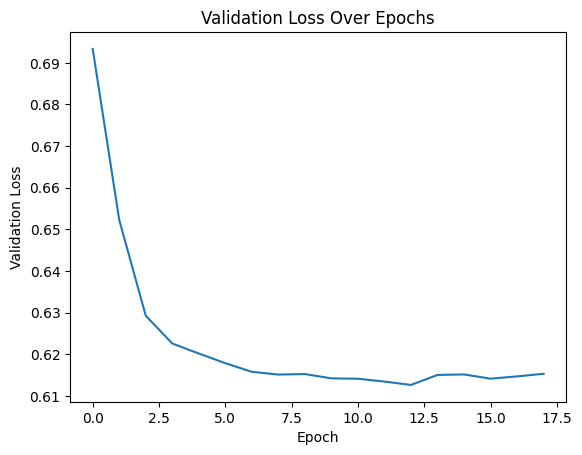

In [8]:
# Extract the best hyperparameters
best_params = grid_result.best_params_
best_num_heads = best_params['model__num_heads']
best_key_dim = best_params['model__key_dim']
best_dropout_rate = best_params['model__dropout_rate']
best_l2_reg = best_params['model__l2_reg']

# Build and compile the final model using the best hyperparameters
final_model = build_attention_model(input_shape=(50, 10),
                                    num_heads=best_num_heads,
                                    key_dim=best_key_dim,
                                    dropout_rate=best_dropout_rate,
                                    l2_reg=best_l2_reg)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = final_model.fit(X_train, y_train,
                          epochs=50,  
                          validation_split=0.2,  
                          callbacks=[early_stopping_callback],
                          verbose=1)

plt.plot(history.history['val_loss'])
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()